## fine-tuning

In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

#from keras.models import *
#from keras.layers import *
#from keras.applications import *
#from keras.preprocessing.image import *
#from keras.callbacks import *
#from keras.optimizers import *
#from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 299, 299

train_data_dir = 'data/train2'
test_data_dir='data/test'

batch_size = 72   #19944/72=277  4986/72=69.25


#模型权重文件
#model_h5file_base="InceptonResNetV2-base-tuning-{}.h5".format(VER)
model_h5file_tunig1="InceptonResNetV2-fine-tuning-1-v2.h5"
model_h5file_tunig2="InceptonResNetV2-fine-tuning-2-v2.h5"
model_h5file_tunig3="InceptonResNetV2-fine-tuning-3-v2.h5"

#预测结果文件
pred_file_base="pred-InceptonResNetV2-base-tuning-v2.csv"
pred_file_tuning1="pred-InceptonResNetV2-fine-tuning-1-v2.csv"
pred_file_tuning2="pred-InceptonResNetV2-fine-tuning-2-v2.csv"
pred_file_tuning3="pred-InceptonResNetV2-fine-tuning-3-v2.csv"

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [5]:
#构造InceptionResNetV2模型
start = time.clock()
x_input = Input((img_width, img_height, 3))
x_input = Lambda(inception_resnet_v2.preprocess_input)(x_input)

base_model = InceptionResNetV2(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.25)(base_model.output) #0.25-->0.5
y = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(y)  #增加正则项
model = Model(inputs=base_model.input, outputs=y)

print("Load base model used time:", (time.clock() - start))


Load base model used time: 33.612499


In [6]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [ ]:
# 输出模型结构图
plot_model(model, to_file='model_InceptionResNetV2.png')

In [7]:
#生成数据--全量读入内存
#X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)
#训练数据
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height)
X_train, Y_train=shuffle(X_train, Y_train)

#测试数据
X_test = load_test_data(12500, img_height, img_width, test_data_dir)


  0%|          | 0/12479 [00:00<?, ?it/s]

dog_nums=12479, cat_nums=12451
total images: 24930


100%|██████████| 12451/12451 [01:28<00:00, 140.95it/s]


In [10]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 299, 299, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         lambda_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation

Total params: 74,436,865
Trainable params: 54,277,729
Non-trainable params: 20,159,136
__________________________________________________________________________________________________


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [11]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如发现loss相比上一个epoch训练没有下降,则经过3个epoch后停止训练
callbacks_list = [stopping,checkpoint]
epochs=20
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/10
19944/19944 [==============================] - 124s 6ms/step - loss: 0.1520 - acc: 0.9673 - val_loss: 0.1055 - val_acc: 0.9767

Epoch 00001: val_loss improved from inf to 0.10551, saving model to InceptonResNetV2-base-tuning-v2.h5
Epoch 2/10
19944/19944 [==============================] - 123s 6ms/step - loss: 0.1365 - acc: 0.9708 - val_loss: 0.0957 - val_acc: 0.9805

Epoch 00002: val_loss improved from 0.10551 to 0.09570, saving model to InceptonResNetV2-base-tuning-v2.h5
Epoch 3/10
19944/19944 [==============================] - 123s 6ms/step - loss: 0.1277 - acc: 0.9705 - val_loss: 0.0843 - val_acc: 0.9838

Epoch 00003: val_loss improved from 0.09570 to 0.08428, saving model to InceptonResNetV2-base-tuning-v2.h5
Epoch 4/10
19944/19944 [==============================] - 123s 6ms/step - loss: 0.1179 - acc: 0.9719 - val_loss: 0.0786 - val_acc: 0.9842

Epoch 00004: val_loss improved from 0.08428 to 0.07860, saving model to Incept

- 注：上面的fit过程，实际上不止10代。因为训练过程中被中断过，加了callbacks参数后，后面继续fit的，所以从当前的输出看，第1代训练输出val_loss就比较低了。

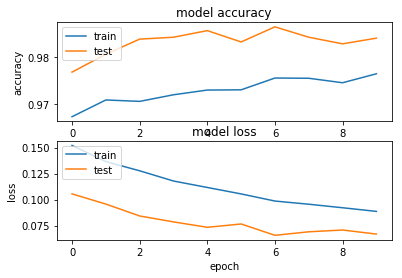

In [12]:
#可视化学习曲线
show_learning_curve(history)

In [14]:
#预测结果   
predict_on_model(X_test, model, model_h5file_base, pred_file_base)

100%|██████████| 12500/12500 [02:36<00:00, 79.69it/s]


12500/12500 [==============================] - 67s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:147: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 151940.67it/s]


## 冻结前698层，再训练
放开Inception-resnet-C第5个block之后的层，不含Inception-resnet-C_5  
698 block8_5_ac 

In [15]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=698)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [16]:
model.load_weights(model_h5file_base)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
#训练模型并保存在验证集上损失函数最小的权重
epochs=10
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/6
19944/19944 [==============================] - 124s 6ms/step - loss: 0.0875 - acc: 0.9768 - val_loss: 0.0581 - val_acc: 0.9854

Epoch 00001: val_loss improved from inf to 0.05807, saving model to InceptonResNetV2-fine-tuning-1-v2.h5
Epoch 2/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0777 - acc: 0.9771 - val_loss: 0.0641 - val_acc: 0.9830

Epoch 00002: val_loss did not improve from 0.05807
Epoch 3/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0750 - acc: 0.9769 - val_loss: 0.0554 - val_acc: 0.9854

Epoch 00003: val_loss improved from 0.05807 to 0.05544, saving model to InceptonResNetV2-fine-tuning-1-v2.h5
Epoch 4/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0699 - acc: 0.9793 - val_loss: 0.0552 - val_acc: 0.9854

Epoch 00004: val_loss improved from 0.05544 to 0.05520, saving model to InceptonResNetV2-fine-tuning-1-v2.h5
Epoch 5/6
19944/19944 [==

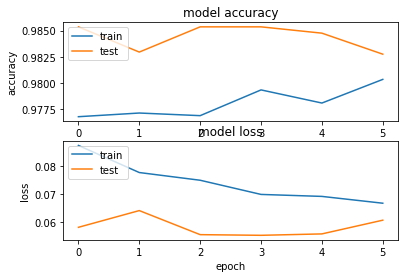

In [18]:
#可视化学习曲线
show_learning_curve(history)

In [20]:
#预测结果
predict_on_model(X_test model, model_h5file_tunig1, pred_file_tuning1)

100%|██████████| 12500/12500 [01:26<00:00, 144.89it/s]


12500/12500 [==============================] - 66s 5ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:147: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 155643.43it/s]


## 冻结前618层，再训练
放开Reduction-B之后的层，不含Reduction-B  
618 mixed_7a

In [21]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=618)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [22]:
model.load_weights(model_h5file_tunig1)  #model_h5file_tunig1比base模型更好
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [23]:
#训练模型并保存在验证集上损失函数最小的权重
epochs=10
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/6
19944/19944 [==============================] - 134s 7ms/step - loss: 0.0694 - acc: 0.9789 - val_loss: 0.0606 - val_acc: 0.9830

Epoch 00001: val_loss improved from inf to 0.06064, saving model to InceptonResNetV2-fine-tuning-2-v2.h5
Epoch 2/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0665 - acc: 0.9789 - val_loss: 0.0558 - val_acc: 0.9848

Epoch 00002: val_loss improved from 0.06064 to 0.05584, saving model to InceptonResNetV2-fine-tuning-2-v2.h5
Epoch 3/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0664 - acc: 0.9803 - val_loss: 0.0573 - val_acc: 0.9840

Epoch 00003: val_loss did not improve from 0.05584
Epoch 4/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.0653 - acc: 0.9805 - val_loss: 0.0579 - val_acc: 0.9838

Epoch 00004: val_loss did not improve from 0.05584
Epoch 5/6
19944/19944 [==============================] - 127s 6ms/step - loss: 0.06

In [24]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig2, pred_file_tuning2)

100%|██████████| 12500/12500 [01:26<00:00, 144.93it/s]


12500/12500 [==============================] - 71s 6ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:147: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 149149.26it/s]


## 冻结前499层，再训练
放开Inception-resnet-B 第17个block之后的层，不含包Inception-resnet-B_17  
499 block17_14_ac

In [25]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=499)

0 input_1
1 lambda_1
2 conv2d_1
3 batch_normalization_1
4 activation_1
5 conv2d_2
6 batch_normalization_2
7 activation_2
8 conv2d_3
9 batch_normalization_3
10 activation_3
11 max_pooling2d_1
12 conv2d_4
13 batch_normalization_4
14 activation_4
15 conv2d_5
16 batch_normalization_5
17 activation_5
18 max_pooling2d_2
19 conv2d_9
20 batch_normalization_9
21 activation_9
22 conv2d_7
23 conv2d_10
24 batch_normalization_7
25 batch_normalization_10
26 activation_7
27 activation_10
28 average_pooling2d_1
29 conv2d_6
30 conv2d_8
31 conv2d_11
32 conv2d_12
33 batch_normalization_6
34 batch_normalization_8
35 batch_normalization_11
36 batch_normalization_12
37 activation_6
38 activation_8
39 activation_11
40 activation_12
41 mixed_5b
42 conv2d_16
43 batch_normalization_16
44 activation_16
45 conv2d_14
46 conv2d_17
47 batch_normalization_14
48 batch_normalization_17
49 activation_14
50 activation_17
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 batch_normalization_13
55 batch_normalization_15
56 batch_n

In [28]:
model.load_weights(model_h5file_tunig2) #哪个模型好，加载哪个
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [29]:
#训练模型并保存在验证集上损失函数最小的权重
epochs=10
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)


Train on 19944 samples, validate on 4986 samples
Epoch 1/6
19944/19944 [==============================] - 130s 7ms/step - loss: 0.0628 - acc: 0.9806 - val_loss: 0.0564 - val_acc: 0.9844

Epoch 00001: val_loss improved from inf to 0.05644, saving model to InceptonResNetV2-fine-tuning-3-v2.h5
Epoch 2/6
19944/19944 [==============================] - 121s 6ms/step - loss: 0.0636 - acc: 0.9793 - val_loss: 0.0559 - val_acc: 0.9842

Epoch 00002: val_loss improved from 0.05644 to 0.05586, saving model to InceptonResNetV2-fine-tuning-3-v2.h5
Epoch 3/6
19944/19944 [==============================] - 121s 6ms/step - loss: 0.0617 - acc: 0.9808 - val_loss: 0.0578 - val_acc: 0.9830

Epoch 00003: val_loss did not improve from 0.05586
Epoch 4/6
19944/19944 [==============================] - 121s 6ms/step - loss: 0.0610 - acc: 0.9803 - val_loss: 0.0604 - val_acc: 0.9817

Epoch 00004: val_loss did not improve from 0.05586
Epoch 5/6
19944/19944 [==============================] - 121s 6ms/step - loss: 0.06

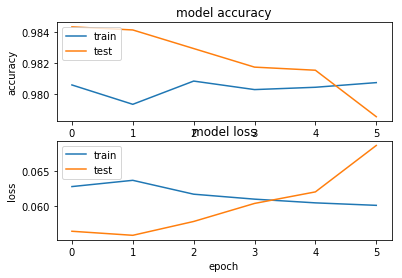

In [30]:
#可视化学习曲线
show_learning_curve(history)

可以看出，明显过拟合

In [ ]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig3, pred_file_tuning3)